In [1]:
from loading.loadIDS import loadIDS, trainIDS
from loading.loadGAN import load_gan, load_gan_kdd
from loading.loadingKDD import loadingKDD
from generation.generation import generation_fake_data
from training.training_gan import train_gan, train_gan_kdd
from matplotlib import pyplot as plt
import numpy as np

# Parameters

# DATA
# x_train, y_train, x_test, y_test = loadData(nrows=100000, attacks=True)
attack_mode = None
X, Y, colnames = loadingKDD(nrows=100000, attack_mode=attack_mode, attack=None)
# assert len(colnames) == 122, "You did not load enough data"
x_test, y_test = X[:3000], Y[:3000]
x_train, y_train = X[:-3000], Y[:-3000]
zero_index_train = [i for y, i in zip(y_train, range(len(y_train))) if y == 0]
zero_index_test = [i for y, i in zip(y_test, range(len(y_test))) if y == 0]
one_index_train = [i for y, i in zip(y_train, range(len(y_train))) if y == 1]
one_index_test = [i for y, i in zip(y_test, range(len(y_test))) if y == 1]
balanced_size = min(len(zero_index_train), len(one_index_train))
if attack_mode is None:
    x_balanced_train = np.concatenate((x_train[zero_index_train][:balanced_size],
                                       x_train[one_index_train][:balanced_size]))
    y_balanced_train = np.concatenate((y_train[zero_index_train][:balanced_size],
                                       y_train[one_index_train][:balanced_size]))
elif attack_mode is False:
    x_balanced_train = x_train[zero_index_train]
    y_balanced_train = y_train[zero_index_train]
elif attack_mode:
    x_balanced_train = x_train[one_index_train]
    y_balanced_train = y_train[one_index_train]

"""
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5)/127.5
x_test = (x_test.astype(np.float32) - 127.5)/127.5
x_train = x_train.reshape(60000, 784)
"""


data_dim = x_train.shape[1]

Using TensorFlow backend.
/home/peseux/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [8]:
y_balanced_test.sum()

NameError: name 'y_balanced_test' is not defined

Instructions for updating:
Colocations handled automatically by placer.
Chosen Optimizer is ADAM
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


  0%|          | 0/1 [00:00<?, ?it/s]

Compiled GAN
Epochs: 1
Batch size: 128
Batches per epoch: 404
Instructions for updating:
Use tf.cast instead.


/home/peseux/Desktop/gitELECOM/IDSGAN/training/training_gan.py:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  real_data = x_train[index]
100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


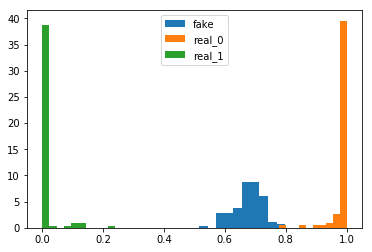

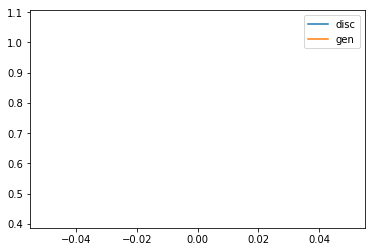

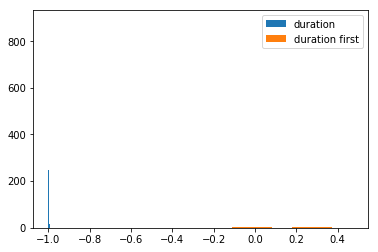

In [9]:
# IDS
ids = loadIDS(mode="RandomForest", n_estimators=200,max_depth=15)
trainIDS(ids, x_train=x_balanced_train, y_train=y_balanced_train)

# GAN
epochs = 1
random_dim = 32
generator, discriminator, gan = load_gan_kdd(data_dim=data_dim,
                                             random_dim=random_dim,
                                             offset=5,
                                             alpha=5,
                                             link_mode="alpha")

number = 100
fake_data_first = generation_fake_data(generator=generator, number=number, random_dim=random_dim)
# Training GAN
gan_to_be_used, discriminator_loss, generator_loss = train_gan_kdd(disc=discriminator,
                                                                   dLossLimit=-1000,
                                                                   gen=generator,
                                                                   GAN=gan,
                                                                   random_dim=random_dim,
                                                                   epochs=epochs,
                                                                   x_train=x_train[zero_index_train])


# Testing IDS
number = 100
fake_data = generation_fake_data(generator=generator, number=number, random_dim=random_dim)
real_data = x_test[zero_index_test][:number]
real_data_one = x_test[one_index_test][:number]
prediction = ids.predict_proba(fake_data)
prediction = [p[] for p in prediction]
prediction_real = ids.predict_proba(real_data)
prediction_real = [p[0] for p in prediction_real]
prediction_real_one = ids.predict_proba(real_data_one)
prediction_real_one = [p[0] for p in prediction_real_one]


plt.hist(prediction, density=True, label="fake")
plt.hist(prediction_real, label="real_0", density=True)
plt.hist(prediction_real_one, label="real_1", density=True)
plt.legend()
plt.show()
plt.close()

plt.plot(discriminator_loss, label="disc")
plt.plot(generator_loss, label="gen")
plt.legend()
plt.show()
plt.close()


plt.hist([f[0] for f in fake_data], label="duration", density=True)
plt.hist([f[0] for f in fake_data_first], label="duration first", density=True)
plt.legend()
plt.show()
plt.close()

In [10]:
y_test[zero_index_test][:number]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
prediction = ids.predict_proba(fake_data)


In [12]:
prediction

array([[0.6491171 , 0.3508829 ],
       [0.6       , 0.4       ],
       [0.6990192 , 0.3009808 ],
       [0.605     , 0.395     ],
       [0.68937665, 0.31062335],
       [0.625     , 0.375     ],
       [0.66935051, 0.33064949],
       [0.63431278, 0.36568722],
       [0.68933179, 0.31066821],
       [0.73425266, 0.26574734],
       [0.69682178, 0.30317822],
       [0.75423589, 0.24576411],
       [0.65935051, 0.34064949],
       [0.71935417, 0.28064583],
       [0.69933918, 0.30066082],
       [0.70433918, 0.29566082],
       [0.74424055, 0.25575945],
       [0.67933918, 0.32066082],
       [0.68649047, 0.31350953],
       [0.65636068, 0.34363932],
       [0.66921497, 0.33078503],
       [0.72831278, 0.27168722],
       [0.70431964, 0.29568036],
       [0.68438798, 0.31561202],
       [0.72435417, 0.27564583],
       [0.71919702, 0.28080298],
       [0.71437622, 0.28562378],
       [0.6963394 , 0.3036606 ],
       [0.68437665, 0.31562335],
       [0.71432851, 0.28567149],
       [0.